In [1]:
import os 
import glob
import numpy as np
import itertools
import pandas as pd

from tqdm import tqdm
import plotly 
import plotly.express as px

import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import shap
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

# Dacon plotly 그림 업로드 
pd.options.plotting.backend = 'plotly'
## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정해주시기 바랍니다.
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#options 
pd.set_option('display.max_columns', None)
rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. Dataset 확인

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
gender = pd.read_csv('./data/age_gender_info.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,2952.0,886.661247,513.540168,26.00,513.50,779.00,1106.0000,2568.0
전용면적,2952.0,44.757215,31.874280,12.62,32.10,39.93,51.5625,583.4
전용면적별세대수,2952.0,102.747967,132.640159,1.00,14.00,60.00,144.0000,1865.0
공가수,2952.0,12.921070,10.778831,0.00,4.00,11.00,20.0000,55.0
지하철,2741.0,0.176578,0.427408,0.00,0.00,0.00,0.0000,3.0
버스,2948.0,3.695726,2.644665,0.00,2.00,3.00,4.0000,20.0
단지내주차면수,2952.0,601.668360,396.407072,13.00,279.25,517.00,823.0000,1798.0
등록차량수,2952.0,559.768293,433.375027,13.00,220.00,487.00,770.0000,2550.0


In [5]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,1022.0,862.080235,536.340894,75.00,488.000,745.00,1161.0,2572.0
전용면적,1022.0,43.706311,35.890759,9.96,33.135,39.72,47.4,583.4
전용면적별세대수,1022.0,100.414873,125.997855,1.00,14.000,60.00,140.0,1341.0
공가수,1022.0,15.544031,11.070140,0.00,6.000,15.00,23.0,45.0
지하철,980.0,0.136735,0.435500,0.00,0.000,0.00,0.0,2.0
버스,1022.0,4.626223,5.414568,1.00,2.000,3.00,5.0,50.0
단지내주차면수,1022.0,548.771037,342.636703,29.00,286.000,458.00,711.0,1696.0


# 1.1 Null data check

In [6]:
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train[col].isna().sum() / train[col].shape[0]))
    print(msg)

column:       단지코드	 Percent of NaN value: 0.00%
column:       총세대수	 Percent of NaN value: 0.00%
column:     임대건물구분	 Percent of NaN value: 0.00%
column:         지역	 Percent of NaN value: 0.00%
column:       공급유형	 Percent of NaN value: 0.00%
column:       전용면적	 Percent of NaN value: 0.00%
column:   전용면적별세대수	 Percent of NaN value: 0.00%
column:        공가수	 Percent of NaN value: 0.00%
column:         신분	 Percent of NaN value: 0.00%
column:      임대보증금	 Percent of NaN value: 19.28%
column:        임대료	 Percent of NaN value: 19.28%
column:        지하철	 Percent of NaN value: 7.15%
column:         버스	 Percent of NaN value: 0.14%
column:    단지내주차면수	 Percent of NaN value: 0.00%
column:      등록차량수	 Percent of NaN value: 0.00%


In [7]:
for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (test[col].isna().sum() / test[col].shape[0]))
    print(msg)

column:       단지코드	 Percent of NaN value: 0.00%
column:       총세대수	 Percent of NaN value: 0.00%
column:     임대건물구분	 Percent of NaN value: 0.00%
column:         지역	 Percent of NaN value: 0.00%
column:       공급유형	 Percent of NaN value: 0.00%
column:       전용면적	 Percent of NaN value: 0.00%
column:   전용면적별세대수	 Percent of NaN value: 0.00%
column:        공가수	 Percent of NaN value: 0.00%
column:         신분	 Percent of NaN value: 0.20%
column:      임대보증금	 Percent of NaN value: 17.61%
column:        임대료	 Percent of NaN value: 17.61%
column:        지하철	 Percent of NaN value: 4.11%
column:         버스	 Percent of NaN value: 0.00%
column:    단지내주차면수	 Percent of NaN value: 0.00%


- train에서는 [임대보증금, 임대료, 지하철, 버스]
- test에서는 [신분, 임대보증금, 임대료, 지하철]에서 Null data를 확인할 수 있다.

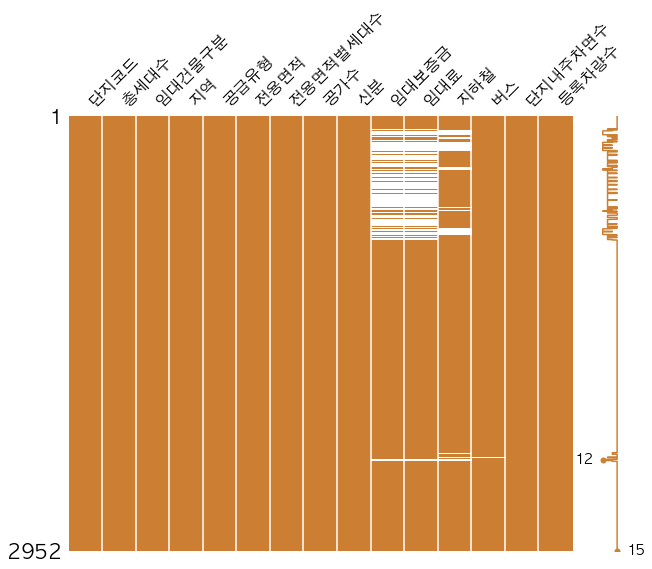

In [8]:
msno.matrix(df=train.iloc[:, :], figsize=(10, 8), color=(0.8, 0.5, 0.2))
plt.show()

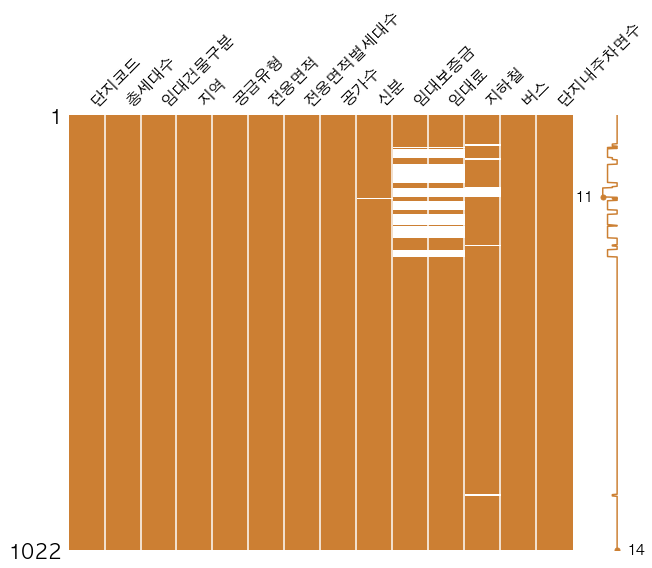

In [9]:
msno.matrix(df=test.iloc[:, :], figsize=(10, 8), color=(0.8, 0.5, 0.2))
plt.show()

# 2. Exploratory data analysis

In [10]:
train[['단지코드', '등록차량수']].groupby(['단지코드'], as_index=True).count().plot()

In [11]:
train[['지역', '등록차량수']].groupby(['지역'], as_index=True).count().plot()

In [12]:
train[['신분', '등록차량수']].groupby(['신분'], as_index=True).count().plot()

### skew된 데이터 확인


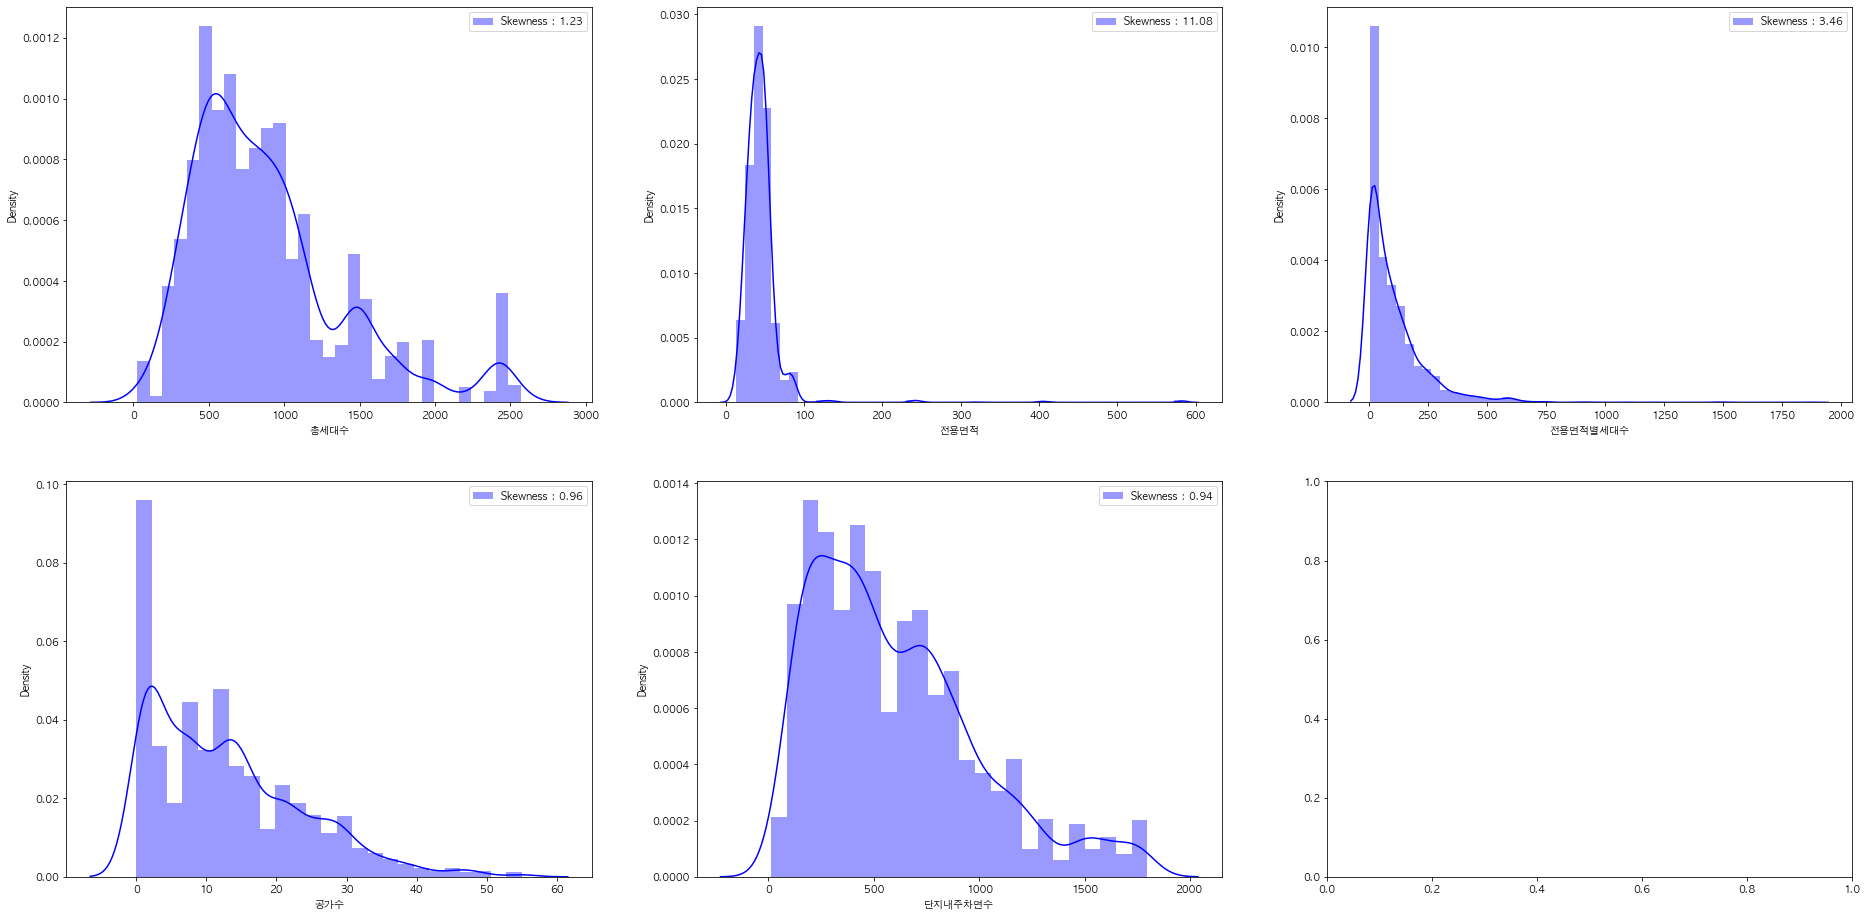

In [13]:
fig, axs = plt.subplots(figsize=(32,16) , ncols=3 , nrows=2)
skew_columns = ['총세대수', '전용면적', '전용면적별세대수', '공가수', '단지내주차면수']
for i , feature in enumerate(skew_columns):
    row = int(i/3)
    col = i%3
    g = sns.distplot(train[feature], 
                 color='b', 
                 label='Skewness : {:.2f}'.format(train[feature].skew()), 
                 ax=axs[row][col])
    g = g.legend(loc='best')

In [ ]:
train['전용면적'] = train['전용면적'].map(lambda i: np.log(i) if i > 0 else 0)
test['전용면적'] = test['전용면적'].map(lambda i: np.log(i) if i > 0 else 0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(train['단지내주차면수'], color='b', label='Skewness : {:.2f}'.format(train['단지내주차면수'].skew()), ax=ax)
g = g.legend(loc='best')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(train['전용면적'], color='b', label='Skewness : {:.2f}'.format(train['전용면적'].skew()), ax=ax)
g = g.legend(loc='best')

# 3. Feature engineering
## 3.1 Fill Null data
### 3.1.1 Fill Null in Subway

In [14]:
train[train.지하철.isnull()].지역.value_counts()

충청남도     114
대전광역시     93
경상남도       4
Name: 지역, dtype: int64

In [15]:
test[test.지하철.isnull()].지역.value_counts()

충청남도     33
대전광역시     9
Name: 지역, dtype: int64

- 대전광역시는 1, 그 외 충남, 경남은 0으로 처리

In [16]:
def get_subway(location):
    subway = ''
    if location == '대전광역시': subway = 1
    else: subway = 0 # 충남, 경남

    return subway

train['지하철'] = train['지역'].apply(lambda x : get_subway(x))
test['지하철'] = test['지역'].apply(lambda x : get_subway(x))

### 3.1.2 Fill Null in Bus

In [17]:
train[train.버스.isnull()].지역.value_counts()

경상남도    4
Name: 지역, dtype: int64

In [18]:
test[test.버스.isnull()].지역.value_counts()

Series([], Name: 지역, dtype: int64)

**각 지역 버스의 평균값으로 결측치 채우기**

In [19]:
train['버스'].fillna(train['버스'].mean().round(0), inplace = True)

### 3.1.3 Fill Null in Qualification

In [20]:
test[test.신분.isnull()].단지코드.value_counts()

C2253    1
C2411    1
Name: 단지코드, dtype: int64

- C2411은 A로 변경
- C2253은 임대보증금, 임대료 존재하면 C, 없으면 D

In [21]:
test[(test.단지코드=='C2411') | (test.단지코드=='C2253')].head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0,2.0,173.0


In [22]:
test.loc[test.단지코드.isin(['C2411']) & test.신분.isnull(), '신분'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.신분.isnull(), '신분'] = 'C'

### 3.1.4 Fill Null in leasehold deposit & rent

In [23]:
train[['임대보증금','임대료']] = train[['임대보증금', '임대료']].fillna("0").replace("-", "0").astype(int)
test[['임대보증금','임대료']] = test[['임대보증금', '임대료']].fillna("0").replace("-", "0").astype(int)

In [24]:
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train[col].isna().sum() / train[col].shape[0]))
    print(msg)

column:       단지코드	 Percent of NaN value: 0.00%
column:       총세대수	 Percent of NaN value: 0.00%
column:     임대건물구분	 Percent of NaN value: 0.00%
column:         지역	 Percent of NaN value: 0.00%
column:       공급유형	 Percent of NaN value: 0.00%
column:       전용면적	 Percent of NaN value: 0.00%
column:   전용면적별세대수	 Percent of NaN value: 0.00%
column:        공가수	 Percent of NaN value: 0.00%
column:         신분	 Percent of NaN value: 0.00%
column:      임대보증금	 Percent of NaN value: 0.00%
column:        임대료	 Percent of NaN value: 0.00%
column:        지하철	 Percent of NaN value: 0.00%
column:         버스	 Percent of NaN value: 0.00%
column:    단지내주차면수	 Percent of NaN value: 0.00%
column:      등록차량수	 Percent of NaN value: 0.00%


In [25]:
for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (test[col].isna().sum() / test[col].shape[0]))
    print(msg)

column:       단지코드	 Percent of NaN value: 0.00%
column:       총세대수	 Percent of NaN value: 0.00%
column:     임대건물구분	 Percent of NaN value: 0.00%
column:         지역	 Percent of NaN value: 0.00%
column:       공급유형	 Percent of NaN value: 0.00%
column:       전용면적	 Percent of NaN value: 0.00%
column:   전용면적별세대수	 Percent of NaN value: 0.00%
column:        공가수	 Percent of NaN value: 0.00%
column:         신분	 Percent of NaN value: 0.00%
column:      임대보증금	 Percent of NaN value: 0.00%
column:        임대료	 Percent of NaN value: 0.00%
column:        지하철	 Percent of NaN value: 0.00%
column:         버스	 Percent of NaN value: 0.00%
column:    단지내주차면수	 Percent of NaN value: 0.00%


In [46]:
train['전용면적'] = train['전용면적'] // 10*10
train['전용면적'] = np.where(train['전용면적'] > 100, 100, train['전용면적'])
train['전용면적'] = np.where(train['전용면적'] < 15, 15, train['전용면적'])

In [47]:
test['전용면적'] = test['전용면적'] // 10*10
test['전용면적'] = np.where(test['전용면적'] > 100, 100, test['전용면적'])
test['전용면적'] = np.where(test['전용면적'] < 15, 15, test['전용면적'])

In [48]:
train.loc[:,'총전용면적'] = train.loc[:,'전용면적'] * train.loc[:,'전용면적별세대수']

codes = train.단지코드.unique()
areas = np.sort(train.전용면적.unique())

train_edited = pd.DataFrame()
columns = ['단지코드', '등록차량수', '총세대수', '지역', '공가수','지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = train.loc[train.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    train_edited.loc[order, columns] = temp_by_code.loc[0, columns]             
    train_edited.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] !=0:
            train_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
        else:
            train_edited.loc[order, f'면적_{int(area)}'] = 0


train_edited["임대비율"] = train_edited.총임대가구수 / train_edited.총세대수
train_edited["가구당주차면수"] = train_edited.단지내주차면수 / train_edited.총세대수

## gender 정보 병합 
train_edited = pd.merge(train_edited, gender, left_on= [ "지역"], right_on= ["지역"], how='left')


train_edited

,단지코드,등록차량수,총세대수,지역,공가수,지하철,버스,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,C2483,1015.0,900.0,경상북도,38.0,0.0,3.0,1425.0,900.0,0.000000,0.000000,0.165556,0.000000,0.834444,0.0,0.0,0.0,0.0,1.0,1.583333,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,C2515,205.0,545.0,경상남도,17.0,0.0,3.0,624.0,545.0,0.000000,0.000000,0.653211,0.104587,0.242202,0.0,0.0,0.0,0.0,1.0,1.144954,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,C1407,1064.0,1216.0,대전광역시,13.0,1.0,1.0,1285.0,1216.0,0.000000,0.000000,0.320724,0.577303,0.101974,0.0,0.0,0.0,0.0,1.0,1.056743,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,C1945,730.0,755.0,경기도,6.0,0.0,3.0,734.0,755.0,0.000000,0.000000,0.317881,0.000000,0.682119,0.0,0.0,0.0,0.0,1.0,0.972185,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,C1470,553.0,696.0,전라북도,14.0,0.0,2.0,645.0,696.0,0.000000,0.000000,0.364943,0.281609,0.353448,0.0,0.0,0.0,0.0,1.0,0.926724,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,C2586,57.0,90.0,제주특별자치도,7.0,0.0,3.0,66.0,90.0,0.133333,0.466667,0.400000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.733333,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,0.072530,0.088403,0.068930,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082
419,C2035,246.0,492.0,강원도,24.0,0.0,1.0,521.0,492.0,0.000000,0.317073,0.317073,0.365854,0.000000,0.0,0.0,0.0,0.0,1.0,1.058943,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,0.068002,0.087266,0.072177,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
420,C2020,19.0,40.0,부산광역시,7.0,0.0,2.0,25.0,40.0,0.500000,0.125000,0.375000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.625000,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
421,C2437,16.0,90.0,충청북도,12.0,0.0,1.0,30.0,90.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0.034678,0.035339,0.059808,0.061570,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037


In [49]:
test.loc[:,'총전용면적'] = test.loc[:,'전용면적'] * test.loc[:,'전용면적별세대수']

codes = test.단지코드.unique()
areas = np.sort(test.전용면적.unique())

test_edited = pd.DataFrame()
columns = ['단지코드', '총세대수', '지역', '공가수','지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = test.loc[test.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    test_edited.loc[order, columns] = temp_by_code.loc[0, columns]             
    test_edited.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] !=0:
            test_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
        else:
            test_edited.loc[order, f'면적_{int(area)}'] = 0


test_edited["임대비율"] = test_edited.총임대가구수 / test_edited.총세대수
test_edited["가구당주차면수"] = test_edited.단지내주차면수 / test_edited.총세대수
## gender 정보 병합 
test_edited = pd.merge(test_edited, gender, left_on= [ "지역"], right_on= ["지역"], how='left')


test_edited

,단지코드,총세대수,지역,공가수,지하철,버스,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,C1072,754.0,경기도,14.0,0.0,2.0,683.0,754.0,0.000000,0.000000,0.153846,0.347480,0.498674,0.0,0.0,0.0,0.0,1.000000,0.905836,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
1,C1128,1354.0,경기도,9.0,0.0,3.0,1216.0,1354.0,0.000000,0.000000,0.310192,0.262925,0.426883,0.0,0.0,0.0,0.0,1.000000,0.898080,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
2,C1456,619.0,부산광역시,18.0,0.0,16.0,547.0,619.0,0.000000,0.000000,0.399031,0.316640,0.284330,0.0,0.0,0.0,0.0,1.000000,0.883683,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
3,C1840,593.0,전라북도,7.0,0.0,3.0,543.0,593.0,0.000000,0.000000,0.564924,0.293423,0.141653,0.0,0.0,0.0,0.0,1.000000,0.915683,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
4,C1332,1297.0,경기도,11.0,0.0,2.0,1112.0,1297.0,0.000000,0.000000,0.327679,0.437934,0.234387,0.0,0.0,0.0,0.0,1.000000,0.857363,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,C2456,349.0,제주특별자치도,17.0,0.0,4.0,270.0,346.0,0.000000,0.320917,0.395415,0.275072,0.000000,0.0,0.0,0.0,0.0,0.991404,0.773639,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,0.072530,0.088403,0.068930,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082
146,C1266,596.0,충청북도,35.0,0.0,1.0,593.0,591.0,0.000000,0.302013,0.510067,0.179530,0.000000,0.0,0.0,0.0,0.0,0.991611,0.994966,0.034678,0.035339,0.059808,0.061570,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037
147,C2152,120.0,강원도,9.0,0.0,1.0,40.0,120.0,0.000000,0.550000,0.450000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.333333,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,0.068002,0.087266,0.072177,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
148,C1267,675.0,경상남도,38.0,0.0,1.0,467.0,670.0,0.074074,0.465185,0.186667,0.266667,0.000000,0.0,0.0,0.0,0.0,0.992593,0.691852,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010


# 4 Building machine learning model and prediction using the trained model

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.svm import SVR

In [51]:
corr = train_edited.drop(['단지코드'],1,).corr()["등록차량수"].abs().sort_values(ascending=False)
corr

등록차량수        1.000000
단지내주차면수      0.848199
총세대수         0.579290
총임대가구수       0.565676
가구당주차면수      0.476397
면적_70        0.316414
30대(남자)      0.303347
30대(여자)      0.289873
면적_30        0.283405
50대(남자)      0.266140
면적_100       0.260449
면적_20        0.234612
면적_50        0.204213
50대(여자)      0.203076
40대(남자)      0.202237
20대(남자)      0.198262
면적_80        0.196680
면적_60        0.190025
면적_15        0.173557
공가수          0.167420
10대(남자)      0.162642
100대(여자)     0.159708
10대(여자)      0.137323
10대미만(남자)    0.125364
10대미만(여자)    0.124643
버스           0.111243
60대(남자)      0.110685
임대비율         0.094771
80대(여자)      0.085312
20대(여자)      0.071159
90대(여자)      0.070871
지하철          0.047937
90대(남자)      0.046605
60대(여자)      0.043460
면적_40        0.027273
70대(여자)      0.026245
40대(여자)      0.022119
100대(남자)     0.016787
70대(남자)      0.015249
80대(남자)      0.003499
Name: 등록차량수, dtype: float64

In [52]:
X = train_edited.copy()
X = X.loc[:,corr.index[0:20]]
X.drop(['등록차량수', ],axis=1, inplace=True)
feature_names = X.columns.to_list()
# scaler = StandardScaler()
# X = scaler.fit(X).transform(X)

y = train_edited.iloc[:,1]

In [53]:
models = {'RF' : RandomForestRegressor(), 
          'LR': LinearRegression() , 
          'RD' : Ridge(), 
          'LS' : Lasso(), 
          'ET' : ElasticNet(),
          'XGB' : XGBRegressor(), 
          'LGB' : LGB.LGBMRegressor(), 
          'CB' : CatBoostRegressor(logging_level='Silent'), 
          'PLS' : PLSRegression()}

kfold = KFold(n_splits=5, shuffle = True, random_state=0)
answer = []

for model in models.keys():
    scores = cross_val_score(models[model], 
                             X, 
                             y, 
                             cv=kfold, 
                             scoring='neg_mean_absolute_error')
    answer.append(scores)

cross_val_result = pd.DataFrame(answer)
cross_val_result.index = models.keys()
cross_val_result['mean'] = cross_val_result.mean(axis=1)

In [54]:
cross_val_result

,0,1,2,3,4,mean
RF,-142.414824,-116.621294,-114.673059,-120.749762,-138.763333,-126.644454
LR,-139.461653,-123.771701,-110.546918,-305.796352,-133.663121,-162.647949
RD,-138.748540,-127.312024,-116.939788,-128.563335,-130.918751,-128.496488
LS,-139.224551,-126.025627,-117.472257,-126.730904,-131.649221,-128.220512
ET,-137.533804,-124.064445,-135.000941,-138.565949,-145.084258,-136.049879
XGB,-151.999957,-124.726718,-122.326330,-116.541307,-153.464709,-133.811804
LGB,-135.940170,-106.576563,-127.744027,-122.109329,-125.843758,-123.642770
CB,-121.085371,-101.195789,-112.532685,-130.285814,-130.529304,-119.125793
PLS,-142.226294,-127.350508,-136.696227,-300.653549,-153.963912,-172.178098


In [ ]:
sub = pd.DataFrame({
        "code": test["complex_code"],
        "num": predictions
    })
#sub= sub.groupby(['code']).median()
#sub['num']= sub['num'].round()
sub=sub.drop_duplicates(subset=['code'], keep='last')

# sub=sub.reset_index(drop=True)
sub.to_csv(path+'submission.csv',index=False)

In [ ]:
# 데이터 폴더의 파일 가져오기 
csv_files = glob.glob('./data/*.csv')

dataset = {}    # Raw data Dick 자징하기
files = []      # Raw data file 리스트 
for name in csv_files:
    raw = pd.read_csv(name)
    name = os.path.basename(name).split('.')[0] # 파일의 확장자 제외 이름만 가져오기 
    dataset.update({name : raw})    # 데이터 사전 
    files.append(name)              # 파일 이름 리스트 

In [60]:
model = CB = CatBoostRegressor()
model.fit(X, y)

X_test = test_edited[feature_names]

pred = RF.predict(X_test)

submission['num'] = pred
submission.to_csv('./first_submission.csv', index=False)

Learning rate set to 0.033488
0:	learn: 383.9917049	total: 1.03ms	remaining: 1.03s
1:	learn: 378.1369996	total: 2.1ms	remaining: 1.05s
2:	learn: 371.2696336	total: 3.33ms	remaining: 1.11s
3:	learn: 365.1495501	total: 4.45ms	remaining: 1.11s
4:	learn: 358.9622636	total: 5.65ms	remaining: 1.12s
5:	learn: 353.4195637	total: 6.74ms	remaining: 1.12s
6:	learn: 347.5269485	total: 7.9ms	remaining: 1.12s
7:	learn: 342.0810129	total: 9.07ms	remaining: 1.12s
8:	learn: 336.3238653	total: 10.2ms	remaining: 1.13s
9:	learn: 330.9141643	total: 11.4ms	remaining: 1.13s
10:	learn: 326.1640932	total: 12.5ms	remaining: 1.12s
11:	learn: 321.9336781	total: 13.6ms	remaining: 1.12s
12:	learn: 317.7503656	total: 14.7ms	remaining: 1.11s
13:	learn: 312.9830775	total: 15.7ms	remaining: 1.11s
14:	learn: 309.1862412	total: 16.8ms	remaining: 1.11s
15:	learn: 304.3704758	total: 18ms	remaining: 1.1s
16:	learn: 299.2840317	total: 19.2ms	remaining: 1.11s
17:	learn: 295.6656937	total: 20.4ms	remaining: 1.11s
18:	learn: 29

In [61]:
explainer = shap.TreeExplainer(RF) 
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], feature_names)

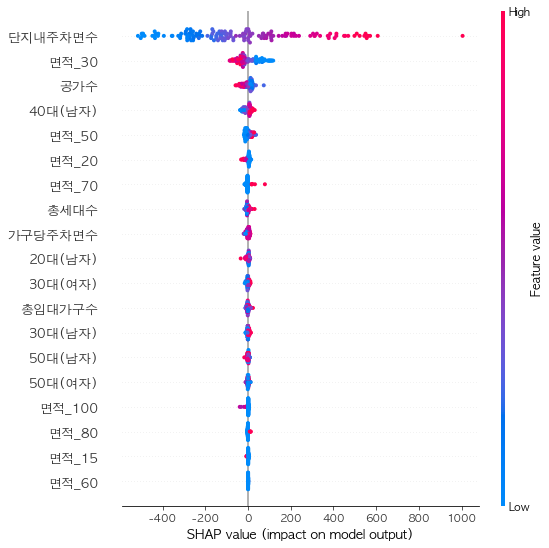

In [62]:
shap.summary_plot(shap_values, X_test,feature_names)